In [1]:
# import library
import os
import shutil
import random
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

In [2]:
# kaggle.json downloaded >> https://drive.google.com/file/d/1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3/view?usp=share_link
! pip install gdown
! gdown 1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3
! ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1x5RMQ3yp049uZIxtIqNg3PwFqOqAAcu3
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 141kB/s]
kaggle.json  sample_data


In [3]:
# Connect the Kaggle API client
! pip install -q kaggle

# move API client in ~/.kaggle
! mkdir ~/.kaggle
! cp "/content/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

# dataset downloaded >> https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [02:39<00:00, 25.2MB/s]
100% 3.58G/3.58G [02:39<00:00, 24.1MB/s]


In [4]:
# extract the zip file
local_zip = "/content/fruits-fresh-and-rotten-for-classification.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content")
zip_ref.close()

In [5]:
# remove unused files
shutil.rmtree("/content/dataset/dataset")
os.remove("fruits-fresh-and-rotten-for-classification.zip")

size of image: (432, 440)


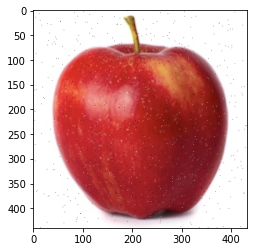

In [6]:
# show sample files
image_path = os.listdir("/content/dataset/train/freshapples")
fruit_sample = random.choice(image_path)
img = tf.keras.preprocessing.image.load_img("/content/dataset/train/freshapples/" + fruit_sample)
plt.imshow(img)
print("size of image: {}".format(img.size))

In [7]:
# directory specification
base_dir = r"/content/dataset"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "test")

# define label variables
labels = os.listdir(validation_dir)

In [8]:
# data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [9]:
# process image
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    class_mode='categorical',)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [10]:
# create sequential models
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

In [11]:
# optimizer and crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [13]:
# callbacks & checkpoint functions
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.99:
      print("\nTarget reached 99%. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

checkpoint_filepath = 'model/model_weights.{epoch:02d}-{val_loss:.3f}.h5'
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True)

In [14]:
# models training
history=model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      verbose=1,
      callbacks=[callbacks, checkpoint_save])

Epoch 1/5
341/341 [==============================] - 74s 190ms/step - loss: 0.7070 - accuracy: 0.7744 - val_loss: 0.4298 - val_accuracy: 0.8521
Epoch 2/5
341/341 [==============================] - 61s 180ms/step - loss: 0.2828 - accuracy: 0.8996 - val_loss: 0.2082 - val_accuracy: 0.9229
Epoch 3/5
341/341 [==============================] - 58s 171ms/step - loss: 0.1404 - accuracy: 0.9516 - val_loss: 0.1693 - val_accuracy: 0.9407
Epoch 4/5
341/341 [==============================] - 57s 168ms/step - loss: 0.1040 - accuracy: 0.9643 - val_loss: 0.1970 - val_accuracy: 0.9281
Epoch 5/5
341/341 [==============================] - 58s 170ms/step - loss: 0.0690 - accuracy: 0.9789 - val_loss: 0.1357 - val_accuracy: 0.9526


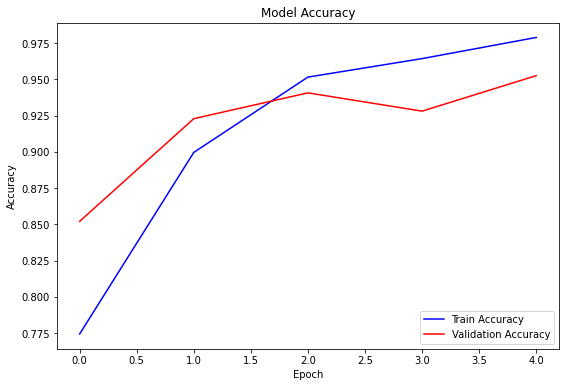

In [15]:
# plotting accuracy metrics
plt.figure(figsize=(9,6))

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

acc = plt.plot(history.history['accuracy'], color='blue')
val_acc = plt.plot(history.history['val_accuracy'], color='red')

plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')

plt.show()

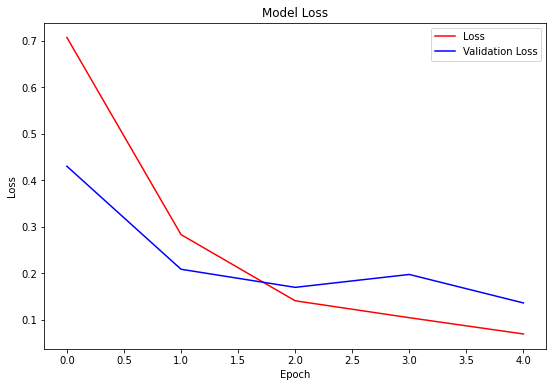

In [16]:
# plotting loss metrics
plt.figure(figsize=(9,6))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

loss = plt.plot(history.history['loss'], color='red')
val_loss = plt.plot(history.history['val_loss'], color='blue')

plt.legend(['Loss', 'Validation Loss'], loc='upper right')

plt.show()

In [17]:
# model conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

model.save("model.h5")

Saving apples-g8d5eabf1e_1920.jpg to apples-g8d5eabf1e_1920 (1).jpg
1/1 [==============================] - 0s 17ms/step
apples-g8d5eabf1e_1920.jpg is a Rotten Apple


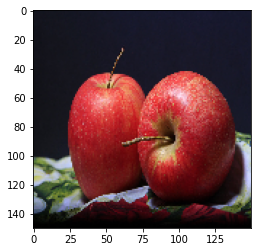

In [22]:
# predict image
%matplotlib inline
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  arr = model.predict(images, batch_size=10)
  if arr[0][0]==1:
    labels='Fresh Apple'
  elif arr[0][1]==1:
    labels='Fresh Banana'
  elif arr[0][2]==1:
    labels='Fresh Oranges'
  elif arr[0][3]==1:
    labels='Rotten Apple'
  elif arr[0][4]==1:
    labels='Rotten Banana'
  elif arr[0][5]==1:
    labels='Rotten Oranges'
print('{} is a {}'.format(fn,labels))